<a href="https://colab.research.google.com/github/PratyushMaharana/kabootar/blob/main/bird_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpreda/xenocanto-birds-from-india")

print("Path to dataset files:", path)

100%|██████████| 1.41M/1.41M [00:00<00:00, 1.89MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/gpreda/xenocanto-birds-from-india/versions/1


UPLOAD CROW AUDIOS


Saving ajh4wib33l-crow-sfx-6.mp3 to ajh4wib33l-crow-sfx-6.mp3
Crow dataset ready

UPLOAD SPARROW AUDIOS


Saving house-sparrow-31116.mp3 to house-sparrow-31116 (2).mp3
Sparrow dataset ready
Model trained successfully
Distance threshold: 0.0

UPLOAD UNKNOWN BIRD AUDIO


Saving cry-of-a-peacock_animal-sound-145793.mp3 to cry-of-a-peacock_animal-sound-145793 (2).mp3

❌ This audio is NOT a Crow or Sparrow


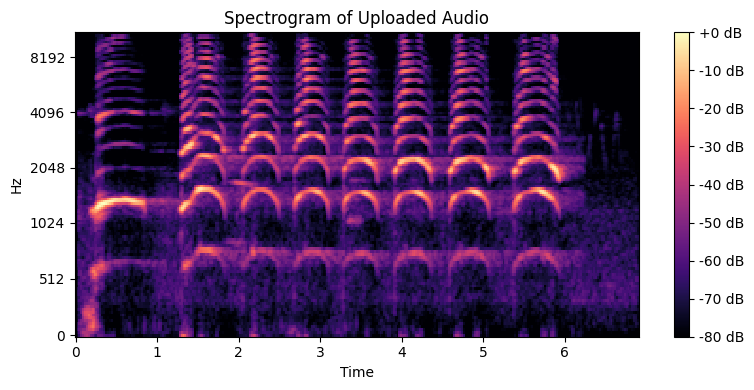

In [5]:
# ==========================================
# BIRD SOUND IDENTIFICATION PROJECT
# Crow + Sparrow + Unknown Detection
# ==========================================

# Install required libraries
!pip install librosa soundfile scikit-learn matplotlib

# ------------------------------------------
# Import Libraries
# ------------------------------------------
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
from sklearn.neighbors import KNeighborsClassifier
from google.colab import files
import pickle

# ------------------------------------------
# Create Dataset Folders
# ------------------------------------------
os.makedirs("dataset/crow", exist_ok=True)
os.makedirs("dataset/sparrow", exist_ok=True)

# ------------------------------------------
# UPLOAD CROW AUDIOS
# ------------------------------------------
print("UPLOAD CROW AUDIOS")
crow_uploaded = files.upload()
crow_files_list = list(crow_uploaded.keys())

i = 1
for file in crow_files_list:
    audio, sr = librosa.load(file, sr=None)
    sf.write(f"dataset/crow/crow_{i}.wav", audio, sr)
    i += 1

print("Crow dataset ready")

# ------------------------------------------
# UPLOAD SPARROW AUDIOS
# ------------------------------------------
print("\nUPLOAD SPARROW AUDIOS")
sparrow_uploaded = files.upload()
sparrow_files_list = list(sparrow_uploaded.keys())

i = 1
for file in sparrow_files_list:
    audio, sr = librosa.load(file, sr=None)
    sf.write(f"dataset/sparrow/sparrow_{i}.wav", audio, sr)
    i += 1

print("Sparrow dataset ready")

# ------------------------------------------
# FEATURE EXTRACTION
# ------------------------------------------
X = []
y = []

for bird in os.listdir("dataset"):
    bird_path = os.path.join("dataset", bird)
    for file in os.listdir(bird_path):
        audio, sr = librosa.load(os.path.join(bird_path, file))
        mfcc = np.mean(
            librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13),
            axis=1
        )
        X.append(mfcc)
        y.append(bird)

X = np.array(X)

# ------------------------------------------
# TRAIN MODEL + THRESHOLD
# ------------------------------------------
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)

distances, _ = model.kneighbors(X)
THRESHOLD = np.max(distances) * 1.2  # safety margin

pickle.dump(model, open("bird_model.pkl", "wb"))

print("Model trained successfully")
print("Distance threshold:", THRESHOLD)

# ------------------------------------------
# UPLOAD UNKNOWN AUDIO
# ------------------------------------------
print("\nUPLOAD UNKNOWN BIRD AUDIO")
test_uploaded = files.upload()
test_filename = list(test_uploaded.keys())[0]

# ------------------------------------------
# PREDICTION
# ------------------------------------------
audio_test, sr_test = librosa.load(test_filename)
mfcc_test = np.mean(
    librosa.feature.mfcc(y=audio_test, sr=sr_test, n_mfcc=13),
    axis=1
)

distance, _ = model.kneighbors([mfcc_test])
distance = distance[0][0]

if distance > THRESHOLD:
    prediction = "unknown"
    print("\n❌ This audio is NOT a Crow or Sparrow")
else:
    prediction = model.predict([mfcc_test])[0]
    print("\n✅ Predicted Bird:", prediction.upper())

# ------------------------------------------
# SPECTROGRAM OF UPLOADED AUDIO
# ------------------------------------------
S_test = librosa.feature.melspectrogram(y=audio_test, sr=sr_test)
S_test_db = librosa.power_to_db(S_test, ref=np.max)

plt.figure(figsize=(8,4))
librosa.display.specshow(S_test_db, sr=sr_test, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram of Uploaded Audio")
plt.tight_layout()
plt.show()

# ------------------------------------------
# REFERENCE SPECTROGRAM (ONLY IF KNOWN)
# ------------------------------------------
if prediction != "unknown":
    reference_file = os.path.join(
        "dataset",
        prediction,
        os.listdir(f"dataset/{prediction}")[0]
    )

    audio_ref, sr_ref = librosa.load(reference_file)

    S_ref = librosa.feature.melspectrogram(y=audio_ref, sr=sr_ref)
    S_ref_db = librosa.power_to_db(S_ref, ref=np.max)

    plt.figure(figsize=(8,4))
    librosa.display.specshow(S_ref_db, sr=sr_ref, x_axis="time", y_axis="mel")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Reference Spectrogram of {prediction.upper()}")
    plt.tight_layout()
    plt.show()
